In [179]:
import pandas as pd
import numpy as np
import time
import math
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data


train = pd.read_csv('../task2/HS300V2_clean_data/clean_train.csv')
test = pd.read_csv('../task2/HS300V2_clean_data/clean_test.csv')

In [180]:
# timer function
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [181]:
def split(train,class_num=2):
    train_process = train.copy()
    class_value=[]
    for i in range(1,class_num+1):
        left = train_process['label'].quantile((i-1)/class_num)
        right = train_process['label'].quantile(i/class_num)
        mid = train_process['label'].quantile((i-0.5)/class_num)
        mask1 = train_process['label']>=left
        mask2 = train_process['label']<right
        mask = mask1 & mask2
        train_process.loc[mask,'label'] = mid
        class_value.append(mid)
    
    # deal with the max value point
    mask = train_process['label'] == right
    train_process.loc[mask,'label'] = mid
    
    # change labels to discrete values
    for i in range(class_num):
        mask = train_process['label']==class_value[i]
        train_process.loc[mask,'label'] = i
        
    train_process['label']=train_process['label'].astype('int64')
    return train_process,class_value

In [277]:
class_num = 2
train_process,class_value = split(train,class_num)

In [278]:
# check the labels
np.array(list(set(train_process['label'])))

array([0, 1])

In [279]:
# design MLP network
class MLP(nn.Module):
    def __init__(self,input_size,class_num):
        super(MLP,self).__init__()
        
        # design hidden layers
        self.fc1 = nn.Linear(inputs_size,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,8)
        self.fc4 = nn.Linear(8,class_num)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(8)
        
        self.dropout = nn.Dropout(p=0.2)
        
        # choose activation function
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid  = nn.Sigmoid()
        self.leakyRelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        
    def forward(self,inputs):
        
        hidden = self.fc1(inputs)
        hidden = self.bn1(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        hidden = self.fc2(hidden)
        hidden = self.bn2(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        hidden = self.fc3(hidden)
        hidden = self.bn3(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        outputs = self.fc4(hidden)
        outputs = self.tanh(outputs)
        
        return outputs

In [280]:
# 95% data as a training set, 5% of data as a validation set
num = len(list(set(train['trade_date'])))
split_date = math.floor(num*0.95)+1215

In [281]:
train_X = train_process[train_process['trade_date']<=split_date].iloc[:,3:]
train_y = train_process[train_process['trade_date']<=split_date].iloc[:,2]
valid_X = train_process[train_process['trade_date']>split_date].iloc[:,3:]
valid_y = train_process[train_process['trade_date']>split_date].iloc[:,2]
test_X = test.iloc[:,2:]

In [282]:
# Convert dataframe to tensor 
train_X = torch.tensor(np.array(train_X),dtype=torch.float32)
train_y = torch.tensor(np.array(train_y),dtype=torch.int64)
valid_X = torch.tensor(np.array(valid_X),dtype=torch.float32)
valid_y = torch.tensor(np.array(valid_y),dtype=torch.int64)
test_X = torch.tensor(np.array(test_X),dtype=torch.float32)

In [283]:
# check the shape of the data
print(train_X.shape,train_y.shape,valid_X.shape,valid_y.shape,test_X.shape)

torch.Size([597174, 282]) torch.Size([597174]) torch.Size([31818, 282]) torch.Size([31818]) torch.Size([108189, 282])


In [284]:
factor_num = train_X.shape[1]
epochs = 10
learning_rate = 1e-4
batch_size = 1024

In [285]:
train_dataset = Data.TensorDataset(train_X,train_y)
valid_dataset = Data.TensorDataset(valid_X,valid_y)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = Data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)

In [292]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#recall:def __init__(self,input_size,class_num):
model = MLP(factor_num,class_num).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

epoch 1 time: 0m 13s
epoch 2 time: 0m 26s
epoch 3 time: 0m 39s
epoch 4 time: 0m 53s
epoch 5 time: 1m 7s
epoch 6 time: 1m 20s
epoch 7 time: 1m 31s
epoch 8 time: 1m 42s
epoch 9 time: 1m 54s
epoch 10 time: 2m 6s


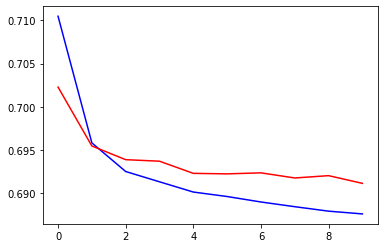

In [293]:
start = time.time()
train_loss = []
valid_loss = [] 
train_epoch_loss = 0
valid_epoch_loss = 0
valid_min_loss = float('inf')
for epoch in range(epochs):
    model.train()
    for t_batch_idx,(t_inputs,t_labels) in enumerate(train_loader):
        t_inputs,t_labels = t_inputs.to(device),t_labels.to(device)
        t_pred = model(t_inputs)
        t_loss = criterion(t_pred,t_labels)
        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_epoch_loss+=t_loss.item()
    
    model.eval()
    for v_batch_idx,(v_inputs,v_labels) in enumerate(valid_loader):
            v_inputs,v_labels = v_inputs.to(device),v_labels.to(device)
            v_pred = model(v_inputs)
            v_loss = criterion(v_pred,v_labels)
            valid_epoch_loss+=v_loss.item()
            
    train_loss.append(train_epoch_loss/(t_batch_idx+1))
    
    # early stop 
    valid_avg_loss = valid_epoch_loss/(v_batch_idx+1)
    if valid_avg_loss/valid_min_loss>1.05:
        break
    else:
        valid_loss.append(valid_avg_loss)
        valid_min_loss = min(valid_loss)
    train_epoch_loss = 0
    valid_epoch_loss = 0 
    print('epoch %d time: %s'% (epoch+1,timeSince(start)))
    
plt.figure()
plt.plot(train_loss,'b-',valid_loss,'r-')
plt.show()

In [295]:
temp = model.cpu()(test_X)
val,idx = temp.max(1)
test_y = torch.zeros(idx.shape[0],1)
for i in range(idx.shape[0]):
    test_y[i]=class_value[idx[i]]
test_y = test_y.detach().numpy()

In [296]:
pred = []
for i in range(test_y.shape[0]):
     pred.append([str(test.iloc[i,1]),str(test.iloc[i,0]),str(test_y[i][0])])

In [297]:
pred

[['3402', '0', '-0.013666096'],
 ['3402', '1', '0.012257789'],
 ['3402', '51', '0.012257789'],
 ['3402', '55', '-0.013666096'],
 ['3402', '63', '0.012257789'],
 ['3402', '69', '-0.013666096'],
 ['3402', '72', '0.012257789'],
 ['3402', '74', '-0.013666096'],
 ['3402', '75', '-0.013666096'],
 ['3402', '78', '-0.013666096'],
 ['3402', '83', '-0.013666096'],
 ['3402', '87', '-0.013666096'],
 ['3402', '88', '-0.013666096'],
 ['3402', '96', '0.012257789'],
 ['3402', '97', '-0.013666096'],
 ['3402', '106', '0.012257789'],
 ['3402', '139', '0.012257789'],
 ['3402', '153', '-0.013666096'],
 ['3402', '167', '-0.013666096'],
 ['3402', '214', '-0.013666096'],
 ['3402', '216', '-0.013666096'],
 ['3402', '219', '-0.013666096'],
 ['3402', '229', '-0.013666096'],
 ['3402', '235', '0.012257789'],
 ['3402', '244', '-0.013666096'],
 ['3402', '270', '-0.013666096'],
 ['3402', '274', '-0.013666096'],
 ['3402', '288', '-0.013666096'],
 ['3402', '291', '0.012257789'],
 ['3402', '318', '-0.013666096'],
 ['340

In [298]:
from BenchmarkTestTool import submit_benchmark_test

data = pred
submitter = "qiuyuan"
dataset = "HS300V2"
comment = 'MLP-classify'
submit_benchmark_test(submitter,data,dataset,comment,submit=False)

TEST STATUS: success
************************************************************
COMPLETENESS CHECK
************************************************************
average_daily_miss_num:  1
max_miss_day:  3763
max_miss_day_num:  4
max_miss_stock:  3337
max_miss_stock_num:  16
pred_miss_num:  38
pred_miss_ratio:  0.0004
pred_num:  108189
true_num:  108227

************************************************************
SUBMIT SIGNAL PERFORMANCE
************************************************************
autocorrelation:  0.5102041823467608
comment:  MLP-classify
dataset:  HS300V2
pearson:  0.030713263193618456
pearson_250:  0.027979438094464012
pearson_decay:  -1.4574981682460646e-05
pearson_std:  0.06413923171235161
sid:  60a40d851cfec313054ca7e0c727f3c4
spearman:  0.04118485884526382
submit_time:  2021-05-10 03:53:22.139278
submitter:  qiuyuan
top30_win_rate:  0.49779005524861875

************************************************************
MODEL SCORE'S EXPOSURE ON RISKS AND INDUSTRIAL 

In [247]:
# from BenchmarkTestTool import check_test_rank

# check_test_rank(submitter="all",rank_by="pearson")

**************************************************
BENCHMARK测试榜排名:
**************************************************
*指标说明:
pearson:皮尔森相关系数
prs_dcy:信号相关性每日衰减系数
prs_250:最近250天（一年）的pearson均值
sprm:序相关性，斯皮尔曼相关系数
top30_win:信号每日前30名有正超额收益的胜率
ac:信号自相关性

0. 
+-------------------+-----------+---------+--------------------------+---------+
|    submit_time    | submitter | dataset |         comment          | pearson |
+-------------------+-----------+---------+--------------------------+---------+
| 21-04-18 13:23:54 |   ZhuLei  | HS300V2 | Person_1e-4_MLP_leakRelu | 0.05882 |
+-------------------+-----------+---------+--------------------------+---------+
+---------+---------+---------+--------+-----------+--------+
| prs_std | prs_dcy | prs_250 |  sprm  | top30_win |   ac   |
+---------+---------+---------+--------+-----------+--------+
|  0.0776 |  -8e-05 |  0.0502 | 0.0468 |   0.497   | 0.5959 |
+---------+---------+---------+--------+-----------+--------+
1. 
+-------------------+--------